In [67]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import cvxopt as opt
from cvxopt import blas, solvers
import plotly.graph_objects as go
from scipy.optimize import minimize, Bounds, LinearConstraint
from matplotlib.cm import ScalarMappable
import scipy.stats
plt.style.use('grayscale')

In [144]:
risk_free = 0.045/12/100
df = pd.read_csv('/Users/frederikfindsen/Documents/GitHub/Project-Finance/data/data.csv', index_col = 'date').drop('Unnamed: 0',axis=1)

In [145]:
airlines = ['DLAKY',
             'LUV',
             'EZJ',
             'RYAAY',
             'UAL',
             'AAL',
             'SAVE']

beer = ['CABGY',
             'HEINY',
             'BUD',
             'HARB-B.CO',
             'DEO',
             'TAP',
             'TSGTF',
             'ASBRF']

In [70]:
#Functions
def rand_weights(n):
    k = np.random.rand(n)
    return k / sum(k)

def portfolio_annualised_performance(weights, mean_returns, cov_matrix):
    
    returns = np.sum(mean_returns*weights)*12
    std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(12)
    
    return std, returns

  
def random_portfolios(returns, num_portfolios=10000, risk_free_rate=risk_free):
    
    mean_returns = returns.mean()
    cov_matrix = returns.cov()
    N = len(returns.columns)
    
    results = np.zeros((3,num_portfolios))
    weights_record = []
    
    results = pd.DataFrame({'return':[],'std':[],'sharperatio':[]})
    
    for i in range(num_portfolios):
        
        weights = np.random.random(N)
        weights /= np.sum(weights)
        weights_record.append(weights)
        std_dev, port_return = portfolio_annualised_performance(weights, mean_returns, cov_matrix)
        
        results.loc[len(results.index)] = [port_return, std_dev,(port_return - risk_free_rate) / std_dev]
    
    return results, weights_record


def volatiltiy(W, exp_ret, cov):
    
    vol = np.sqrt(np.dot(W.T, np.dot(cov, W))) * np.sqrt(12)
    
    return vol


# Function that runs optimizer

def optimize(func, target_return, exp_ret, cov, opt_bounds):
    W = np.ones((exp_ret.shape[0],1))*(1.0/exp_ret.shape[0])
    
    opt_constraints = ({'type': 'eq',
                        'fun': lambda W: 1.0 - np.sum(W)},
                       {'type': 'eq',
                        'fun': lambda W: target_return - W.T@exp_ret})
    
    optimal_weights = minimize(func, W, 
                               args=(exp_ret, cov),
                               method='SLSQP',
                               bounds=opt_bounds,
                               constraints=opt_constraints)
    
    return optimal_weights['x']

def optimize_min(func, exp_ret, cov, opt_bounds):
    W = np.ones((exp_ret.shape[0],1))*(1.0/exp_ret.shape[0])
    
    opt_constraints = ({'type': 'eq',
                        'fun': lambda W: 1.0 - np.sum(W)})
    
    optimal_weights = minimize(func, W, 
                               args=(exp_ret, cov),
                               method='SLSQP',
                               bounds=opt_bounds,
                               constraints=opt_constraints)
    
    std, ret = portfolio_annualised_performance(optimal_weights['x'],exp_ret,cov)
    
    return [std, ret]

def efficient_frontier(df, opt_bounds, risk_free=risk_free):
    
    target_return_range = np.linspace(0,0.2,200) #Range for iterating through different optimal returns

    efficient_df = pd.DataFrame({'return':[],'std':[],'sharperatio':[],'weights':[]})
    efficient_port = list()

    min_port = optimize_min(volatiltiy, exp_ret = df.mean(), cov = df.cov(), opt_bounds = opt_bounds)
    
    for returns in target_return_range: #Creating efficient frontier
        
        x = optimize(volatiltiy,
                     returns, 
                     exp_ret = df.mean(), 
                     cov = df.cov(),
                     opt_bounds = opt_bounds)
        
        efficient_port.append(x)
        
        std, returns = portfolio_annualised_performance(x,df.mean(),df.cov())
        
        efficient_df.loc[len(efficient_df.index)] = [returns, std, (returns - risk_free) / std, x]

    return efficient_df, min_port

def plot_efficientfrontier(efficient_df_list,info_df=None, titles=None, min_port=None):
    
    fig, axes = plt.subplots(2,len(efficient_df_list),figsize=(15,8))
    
    for df, i in zip(efficient_df_list,range(len(efficient_df_list))): 
        
        axes[0][i].plot(df['std'],df['return'])
        axes[0][i].set_xlabel('Standard Deviation, Annualized')
        axes[0][i].set_ylabel('Expected Return, Annualized')
        
        axes[0][i].set_ylim(-0.05,0.25)
        axes[0][i].set_xlim(-0.05,0.5)
        
        axes[1][i].bar(np.arange(len(info_df[i]['stock'])),df[df['std']==df['std'].min()]['weights'].values[0],width=0.2) 
        
        axes[1][i].set_xticks(np.arange(len(info_df[i]['stock']))) 
        axes[1][i].set_xticklabels(info_df[i]['stock'],rotation = 55)
        axes[1][i].set_title('Min Port Weights')
        
    if info_df != None:
        for stocks_df, i in zip(info_df,range(len(efficient_df_list))):
            for index, row in stocks_df.iterrows():
                axes[0][i].scatter(row['std'],row['return'])
                axes[0][i].annotate(row['stock'], (row['std'], row['return']), xytext=(5,5), textcoords='offset points')
    
    if titles != None:
        for title, i in zip(titles,range(len(titles))): 
            axes[0][i].set_title(title)
    
    if min_port != None:
        for port, i in zip(min_port,range(len(min_port))): 
            axes[0][i].scatter(port[0],port[1])
            axes[0][i].annotate('Min. Port' ,(port[0],port[1]),xytext=(5,5), textcoords='offset points') 
    
    fig.tight_layout()
    
    return fig, axes

def tangent_plot():
    
    fig, axes = plt.subplots(1,len(efficient_df_list),figsize=(15,5))
    
    for df, i in zip(efficient_df_list,range(len(efficient_df_list))): 
        axes[i].plot(df['std'],df['return'])
        axes[i].set_xlabel('Standard Deviation, Annualized')
        axes[i].set_ylabel('Expected Return, Annualized')
    
    if info_df != None:
        for stocks_df, i in zip(info_df,range(len(efficient_df_list))):
            for index, row in stocks_df.iterrows():
                axes[i].scatter(row['std'],row['return'])
                axes[i].annotate(row['stock'], (row['std'], row['return']), xytext=(5,5), textcoords='offset points')
    
    if titles != None:
        for title, i in zip(titles,range(len(titles))): 
            axes[i].set_title(title)
    
    if min_port != None:
        for port, i in zip(min_port,range(len(min_port))): 
            axes[i].scatter(port[0],port[1])
            axes[i].annotate('Min. Port' ,(port[0],port[1]),xytext=(5,5), textcoords='offset points') 
            
            
    fig.tight_layout()
    
def calc_risk(df, returns_df, value, alpha, b = 500, n=120):
    
    weighted_returns = (df[df['std']== df['std'].min()]['weights'].values[0] * returns_df)
    returns = weighted_returns.sum(axis=1)
        
    boot_data = list()
    var = -value*(returns.mean()+scipy.stats.norm.ppf(alpha)*returns.std()) 
    
    for i in range(b):
        boot_sample = returns.sample(n)
        boot_data.append(-value*(boot_sample.mean()+scipy.stats.norm.ppf(alpha)*boot_sample.std()))
    
    range_1 = 2*returns.mean()-np.quantile(boot_data,1-alpha/2)
    range_2 = 2*returns.mean()-np.quantile(boot_data,alpha/2)
    
    return [range_1,range_2]

def make_port(req_return, exp_ret, cov, bounds):
    weights = optimize(volatiltiy,
                    req_return, 
                    exp_ret = exp_ret, 
                    cov = cov,
                    opt_bounds = bounds)
    
    std, ret = portfolio_annualised_performance(weights, exp_ret, cov)
    port = pd.DataFrame({'std':std,'ret':ret,'weight':[weights]})
    return port 


### Efficient Frontier and Min variance portfolio without Risk Free Asset

In [134]:
airlines_df = df[airlines]
beer_df = df[beer]

airlines_info = pd.DataFrame({'stock':airlines,
                              'return':airlines_df.mean().values*12,
                              'std':airlines_df.std().values*np.sqrt(12)})

beer_info = pd.DataFrame({'stock':beer,
                          'return':beer_df.mean().values*12,
                          'std':beer_df.std().values*np.sqrt(12)})

all_info = pd.DataFrame({'stock':df.columns,
                         'return':df.mean().values*12,
                         'std':df.std().values*np.sqrt(12)})

info_df_list = [airlines_info, beer_info, all_info]
df_list = [airlines_df, beer_df, df]

In [72]:
efficient_df_airline, min_port_airline = efficient_frontier(airlines_df,opt_bounds=Bounds(0,1))
efficient_df_beer, min_port_beer = efficient_frontier(beer_df,opt_bounds=Bounds(0,1))
efficient_df, min_port = efficient_frontier(df,opt_bounds=Bounds(0,1))


efficient_df_list = [efficient_df_airline, efficient_df_beer, efficient_df]
min_port_list = [min_port_airline, min_port_beer, min_port]

/Users/frederikfindsen/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


In [73]:
efficient_df_airline_short, min_port_airline_short = efficient_frontier(airlines_df,opt_bounds=Bounds(-np.inf,np.inf))
efficient_df_beer_short, min_port_beer_short = efficient_frontier(beer_df,opt_bounds=Bounds(-np.inf,np.inf))
efficient_df_short, min_port_short = efficient_frontier(df,opt_bounds=Bounds(-np.inf,np.inf))


min_port_list_short = [min_port_airline_short, min_port_beer_short, min_port_short]
efficient_df_list_short = [efficient_df_airline_short, efficient_df_beer_short, efficient_df_short]

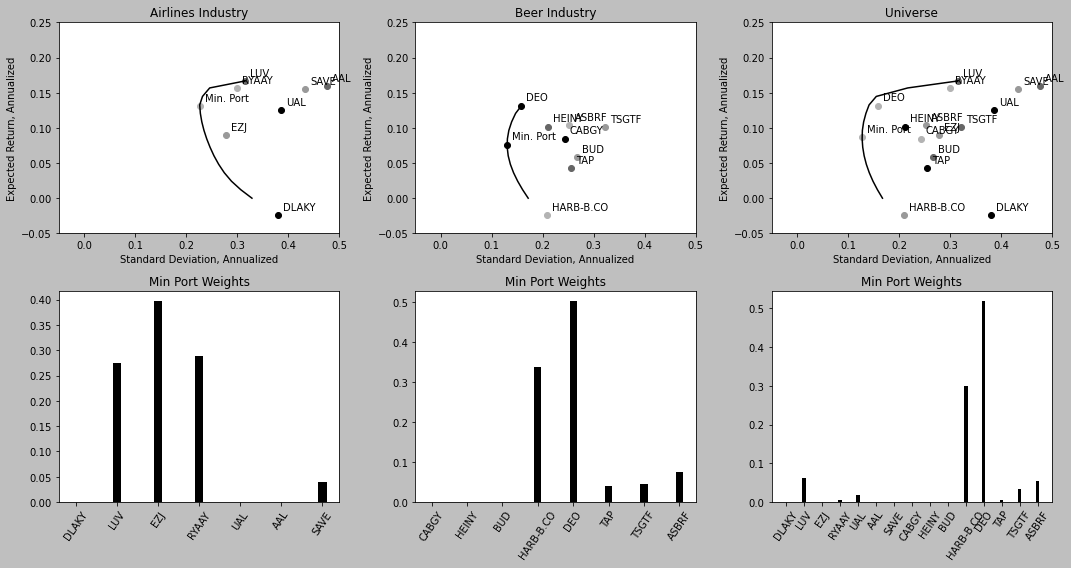

In [74]:
efficient_plot, eff_axes = plot_efficientfrontier(efficient_df_list,
                              info_df_list,
                              titles =['Airlines Industry','Beer Industry','Universe'],
                            min_port = min_port_list)

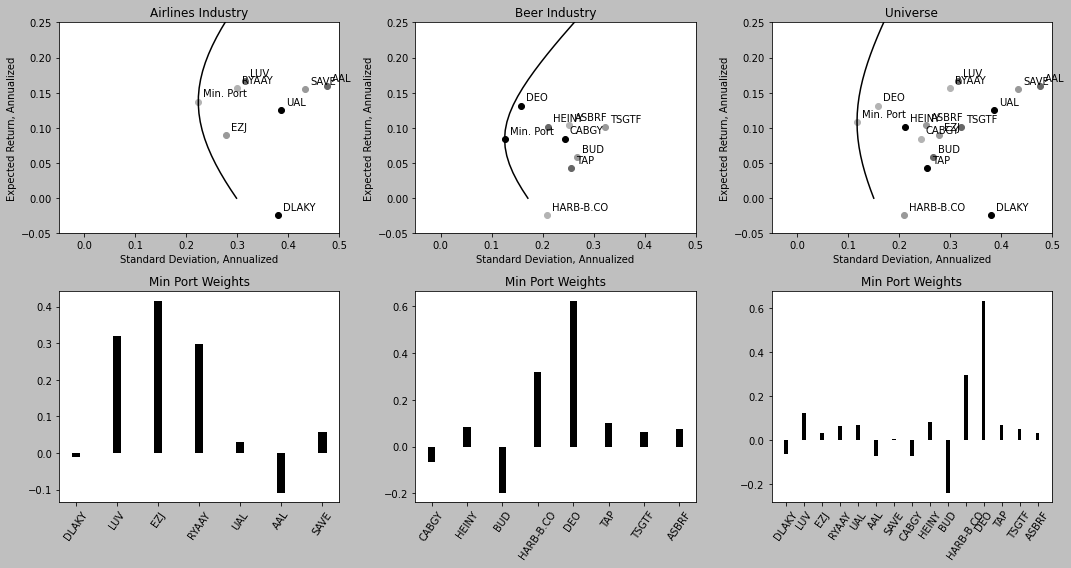

In [75]:
efficient_plot_short, eff_axes_short = plot_efficientfrontier(efficient_df_list_short,
                              info_df_list,
                              titles =['Airlines Industry','Beer Industry','Universe'],
                            min_port = min_port_list_short)

In [76]:
var_list = list()
for port, returns in zip(efficient_df_list,df_list):
    var_list.append(calc_risk(port, returns ,100000,alpha=0.05))
print(pd.DataFrame(var_list))

              0            1
0 -10098.211353 -8754.564572
1  -5656.018736 -5034.168408
2  -5429.305685 -4722.402284


In [77]:
var_list = list()
for port, returns in zip(efficient_df_list_short,df_list):
    var_list.append(calc_risk(port, returns ,100000,alpha=0.05))
    
print(pd.DataFrame(var_list))

             0            1
0 -9969.085803 -8605.356723
1 -5339.992601 -4707.660055
2 -4773.396420 -4198.816082


In [78]:
pd.DataFrame(min_port_list_short)

,0,1
0,0.223370,0.137244
1,0.125149,0.083972
2,0.117301,0.108371


In [79]:
portfolio_list = ['minvarianceport_airline_noshort',
                 'minvarianceport_beer_noshort',
                 'minvarianceport_all_noshort',
                 'minvarianceport_airline_short',
                  'minvarianceport_beer_short',
                 'minvarianceport_all_short']


portreturns_list = list()
for port, df in zip(efficient_df_list,df_list):
    weighted_returns = port[port['std']== port['std'].min()]['weights'].values[0] * df
    returns = weighted_returns.sum(axis=1)
    
    portreturns_list.append(returns.values)

for port, df in zip(efficient_df_list_short,df_list):
    weighted_returns = port[port['std']== port['std'].min()]['weights'].values[0] * df
    returns = weighted_returns.sum(axis=1)
    
    portreturns_list.append(returns.values)
    
portfolios = pd.DataFrame(portreturns_list).T
portfolios.columns = portfolio_list


In [10]:
efficient_plot.savefig('/Users/frederikfindsen/Documents/GitHub/Project-Finance/assets/efficient_plot.png')
efficient_plot_short.savefig('/Users/frederikfindsen/Documents/GitHub/Project-Finance/assets/efficient_plot_short.png')

#### Efficient Portfolio with Risk Free 

In [146]:
df['rf'] = 0.045/12/100
airlines.append('rf')
beer.append('rf')

airlines_df = df[airlines]
beer_df = df[beer]

airlines_info = pd.DataFrame({'stock':airlines,'return':airlines_df.mean().values*12,'std':airlines_df.std().values*np.sqrt(12)})
beer_info = pd.DataFrame({'stock':beer,'return':beer_df.mean().values*12,'std':beer_df.std().values*np.sqrt(12)})
all_info = pd.DataFrame({'stock':df.columns,'return':df.mean().values*12,'std':df.std().values*np.sqrt(12)})

info_df_list = [airlines_info, beer_info, all_info]
df_list = [airlines_df, beer_df, df]

In [81]:
efficient_df_airline, min_port_airline = efficient_frontier(airlines_df,opt_bounds=Bounds(-np.inf,np.inf))
efficient_df_beer, min_port_beer = efficient_frontier(beer_df,opt_bounds=Bounds(-np.inf,np.inf))
efficient_df, min_port = efficient_frontier(df,opt_bounds=Bounds(-np.inf,np.inf))


efficient_df_list_rf = [efficient_df_airline, efficient_df_beer, efficient_df]
min_port_list_rf = [min_port_airline, min_port_beer, min_port]

/Users/frederikfindsen/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


In [82]:
efficient_df_airline, min_port_airline = efficient_frontier(airlines_df,opt_bounds=Bounds(0,1))
efficient_df_beer, min_port_beer = efficient_frontier(beer_df,opt_bounds=Bounds(0,1))
efficient_df, min_port = efficient_frontier(df,opt_bounds=Bounds(0,1))


efficient_df_list_rf_noshort = [efficient_df_airline, efficient_df_beer, efficient_df]
min_port_list_rf_noshort = [min_port_airline, min_port_beer, min_port]

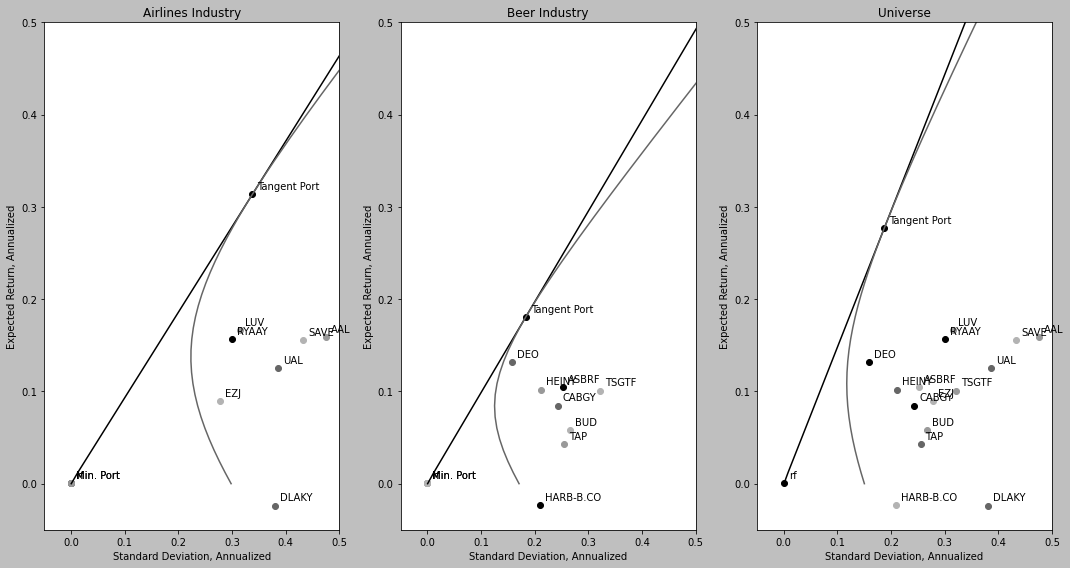

In [100]:
fig, axes = plt.subplots(1,len(efficient_df_list_rf),figsize=(15,8))
titles = ['Airlines Industry', 'Beer Industry', 'Universe']

for df, i in zip(efficient_df_list_rf,range(len(efficient_df_list_rf))): 
    axes[i].plot(df['std'],df['return'])
    axes[i].set_xlabel('Standard Deviation, Annualized')
    axes[i].set_ylabel('Expected Return, Annualized')
    
    axes[i].set_ylim(-0.05,0.5)
    axes[i].set_xlim(-0.05,0.5)
    
    
for df, i in zip(efficient_df_list_short,range(len(efficient_df_list_short))): 
    axes[i].plot(df['std'],df['return'])
    axes[i].set_xlabel('Standard Deviation, Annualized')
    axes[i].set_ylabel('Expected Return, Annualized')
    
    axes[i].scatter(df[df['sharperatio']==df['sharperatio'].max()]['std'],df[df['sharperatio']==df['sharperatio'].max()]['return'])
    axes[i].annotate('Tangent Port' ,
                     (df[df['sharperatio']==df['sharperatio'].max()]['std'],df[df['sharperatio']==df['sharperatio'].max()]['return']),
                     xytext=(5,5), 
                     textcoords='offset points') 

    
for stocks_df, i in zip(info_df_list,range(len(efficient_df_list_rf))):
    for index, row in stocks_df.iterrows():
        axes[i].scatter(row['std'],row['return'])
        axes[i].annotate(row['stock'], (row['std'], row['return']), xytext=(5,5), textcoords='offset points')

for port, i in zip(min_port_list_rf,range(len(min_port))): 
    axes[i].scatter(port[0],port[1])
    axes[i].annotate('Min. Port' ,(port[0],port[1]),xytext=(5,5), textcoords='offset points') 

    
for port, i in zip(min_port_list_rf,range(len(min_port))): 
    axes[i].scatter(port[0],port[1])
    axes[i].annotate('Min. Port' ,(port[0],port[1]),xytext=(5,5), textcoords='offset points')     

for title, i in zip(titles,range(len(titles))): 
    axes[i].set_title(title)

fig.tight_layout()



In [101]:
fig.savefig('/Users/frederikfindsen/Documents/GitHub/Project-Finance/assets/tangent_plot_short.png')

In [109]:
for df in efficient_df_list_short:
    print('std is:',df[df['sharperatio']==df['sharperatio'].max()]['std'].values, 'returns isL', df[df['sharperatio']==df['sharperatio'].max()]['return'].values)

std is: [0.33796439] returns isL [0.31356784]
std is: [0.18350665] returns isL [0.18090452]
std is: [0.18749047] returns isL [0.27738693]


In [138]:
new_columns = ['tangent_airline_short',
               'tangent_beer_short',
              'tangent_all_short']

returns_list = list()

for port, df in zip(efficient_df_list_short, df_list):
    weighted_returns = port[port['sharperatio']==port['sharperatio'].max()]['weights'].values[0] * df
    
    returns = weighted_returns.sum(axis=1).values
    returns_list.append(returns)
    
for returns, name in zip(returns_list,new_columns):
    portfolios[name] = returns



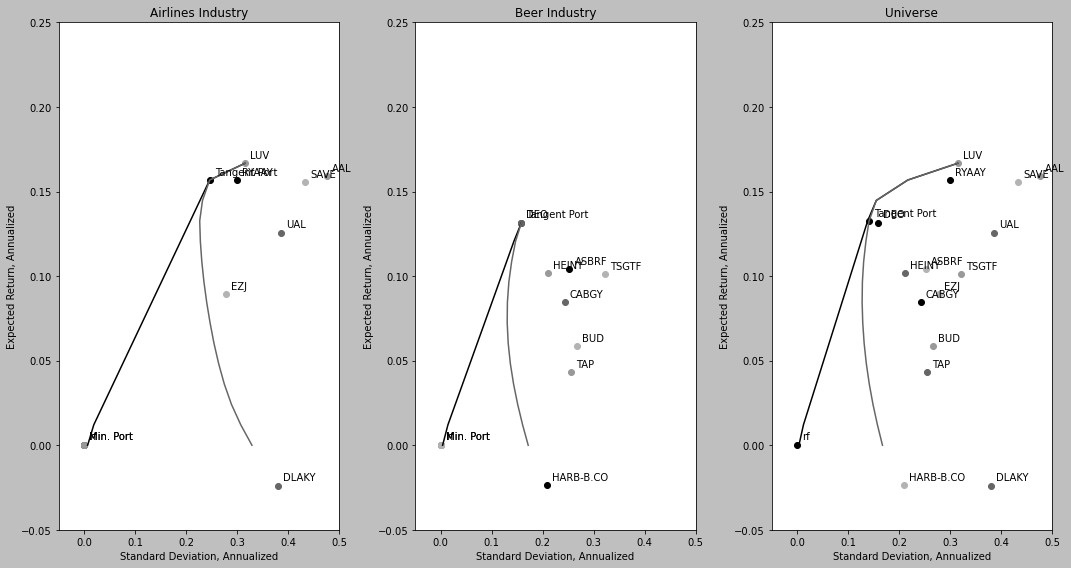

In [102]:
fig, axes = plt.subplots(1,len(efficient_df_list_rf_noshort),figsize=(15,8))

for df, i in zip(efficient_df_list_rf_noshort,range(len(efficient_df_list_rf_noshort))): 
    axes[i].plot(df['std'],df['return'])
    axes[i].set_xlabel('Standard Deviation, Annualized')
    axes[i].set_ylabel('Expected Return, Annualized')
    
    axes[i].set_ylim(-0.05,0.25)
    axes[i].set_xlim(-0.05,0.5)
    
    
for df, i in zip(efficient_df_list,range(len(efficient_df_list))): 
    axes[i].plot(df['std'],df['return'])
    axes[i].set_xlabel('Standard Deviation, Annualized')
    axes[i].set_ylabel('Expected Return, Annualized')
    
    axes[i].scatter(df[df['sharperatio']==df['sharperatio'].max()]['std'],df[df['sharperatio']==df['sharperatio'].max()]['return'])
    axes[i].annotate('Tangent Port' ,
                     (df[df['sharperatio']==df['sharperatio'].max()]['std'],df[df['sharperatio']==df['sharperatio'].max()]['return']),
                     xytext=(5,5), 
                     textcoords='offset points') 

    
for stocks_df, i in zip(info_df_list,range(len(efficient_df_list_rf_noshort))):
    for index, row in stocks_df.iterrows():
        axes[i].scatter(row['std'],row['return'])
        axes[i].annotate(row['stock'], (row['std'], row['return']), xytext=(5,5), textcoords='offset points')

for port, i in zip(min_port_list_rf,range(len(min_port))): 
    axes[i].scatter(port[0],port[1])
    axes[i].annotate('Min. Port' ,(port[0],port[1]),xytext=(5,5), textcoords='offset points') 

    
for port, i in zip(min_port_list_rf,range(len(min_port))): 
    axes[i].scatter(port[0],port[1])
    axes[i].annotate('Min. Port' ,(port[0],port[1]),xytext=(5,5), textcoords='offset points')     

    
for title, i in zip(titles,range(len(titles))): 
    axes[i].set_title(title)

fig.tight_layout()



In [103]:
fig.savefig('/Users/frederikfindsen/Documents/GitHub/Project-Finance/assets/tangent_plot_noshort.png')

In [108]:

for df in efficient_df_list:
    print('std is:',df[df['sharperatio']==df['sharperatio'].max()]['std'].values, 'returns isL', df[df['sharperatio']==df['sharperatio'].max()]['return'].values)

std is: [0.2457256] returns isL [0.15678392]
std is: [0.15823958] returns isL [0.13168602]
std is: [0.14096747] returns isL [0.13266332]


In [139]:
new_columns = ['tangent_airline_noshort',
               'tangent_beer_noshort',
              'tangent_all_noshort']

returns_list = list()

for port, df in zip(efficient_df_list, df_list):
    weighted_returns = port[port['sharperatio']==port['sharperatio'].max()]['weights'].values[0] * df
    
    returns = weighted_returns.sum(axis=1).values
    returns_list.append(returns)
    
for returns, name in zip(returns_list,new_columns):
    portfolios[name] = returns




In [140]:
portfolios

,minvarianceport_airline_noshort,minvarianceport_beer_noshort,minvarianceport_all_noshort,minvarianceport_airline_short,minvarianceport_beer_short,minvarianceport_all_short,tangent_airline_short,tangent_airline_noshort,tangent_beer_short,tangent_all_short,tangent_beer_noshort,tangent_all_noshort
0,-0.040620,-0.030684,-0.028443,-0.037307,-0.019515,-0.014963,-0.085365,-0.056085,0.074585,0.040202,0.032675,-0.002123
1,0.024442,0.004196,0.003656,0.038928,0.000282,0.006157,0.016583,-0.024286,0.023371,0.017376,0.019010,0.010242
2,-0.073424,-0.027722,-0.021819,-0.077765,-0.026290,-0.028801,-0.013993,0.005129,-0.023457,-0.004331,-0.013549,-0.006927
3,0.022013,0.037596,0.032434,0.014678,0.026113,0.008179,-0.047666,0.015325,0.048742,-0.006303,0.067568,0.041483
4,-0.025548,0.014229,0.016451,-0.024235,0.032294,0.033080,-0.037370,-0.015427,0.120146,0.090001,0.045717,0.036278
...,...,...,...,...,...,...,...,...,...,...,...,...
126,-0.020624,0.035354,0.033686,-0.024001,0.049250,0.049975,-0.031659,-0.022491,0.059236,0.065953,0.034013,0.013702
127,0.001964,-0.010539,-0.011196,0.003678,-0.008416,0.000695,0.060723,-0.012960,-0.019075,0.018002,-0.018174,-0.016452
128,0.037635,-0.008853,-0.004341,0.039246,0.005549,0.018892,0.097152,0.029857,0.046309,0.088494,0.004633,0.010867
129,-0.042469,0.009569,0.006764,-0.040134,0.001005,0.011794,0.163885,-0.030320,0.032545,0.101420,0.034560,0.011257


### Part 4

In [28]:
df = pd.read_csv('/Users/frederikfindsen/Documents/GitHub/Project-Finance/data/data.csv', index_col = 'date').drop('Unnamed: 0',axis=1)

airlines_df = df[airlines]
beer_df = df[beer]

airlines_info = pd.DataFrame({'stock':airlines,'return':airlines_df.mean().values*12,'std':airlines_df.std().values*np.sqrt(12)})
beer_info = pd.DataFrame({'stock':beer,'return':beer_df.mean().values*12,'std':beer_df.std().values*np.sqrt(12)})
all_info = pd.DataFrame({'stock':df.columns,'return':df.mean().values*12,'std':df.std().values*np.sqrt(12)})

info_df_list = [airlines_info, beer_info, all_info]

airline_noriskfree = make_port(0.005,airlines_df.mean(),airlines_df.cov(),Bounds(0,1))
beer_noriskfree = make_port(0.005,beer_df.mean(),beer_df.cov(),Bounds(0,1))
all_noriskfree = make_port(0.005, df.mean(), df.cov(),Bounds(0,1))

target_port_list = [airline_noriskfree, beer_noriskfree,all_noriskfree]

In [29]:
df['rf'] = 0.045/12/100
airlines.append('rf')
beer.append('rf')

airlines_df = df[airlines]
beer_df = df[beer]

airlines_info = pd.DataFrame({'stock':airlines,'return':airlines_df.mean().values*12,'std':airlines_df.std().values*np.sqrt(12)})
beer_info = pd.DataFrame({'stock':beer,'return':beer_df.mean().values*12,'std':beer_df.std().values*np.sqrt(12)})
all_info = pd.DataFrame({'stock':df.columns,'return':df.mean().values*12,'std':df.std().values*np.sqrt(12)})

info_df_list_rf = [airlines_info, beer_info, all_info]

airline_riskfree = make_port(0.005,airlines_df.mean(),airlines_df.cov(),Bounds(0,1))
beer_riskfree = make_port(0.005,beer_df.mean(),beer_df.cov(),Bounds(0,1))
all_riskfree = make_port(0.005, df.mean(), df.cov(),Bounds(0,1))

target_port_list_rf = [airline_riskfree, beer_riskfree,all_riskfree]

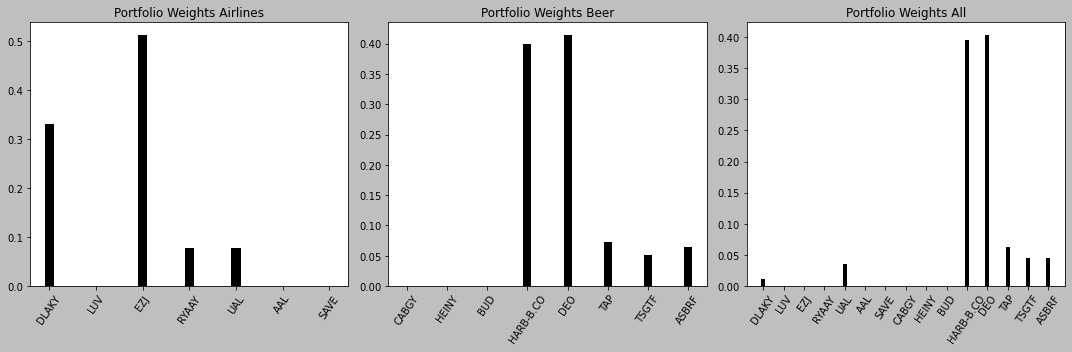

In [30]:
fig, axes = plt.subplots(1,3,figsize=(15,5))
names = ['Airlines', 'Beer', 'All']

for i, port in zip(range(len(target_port_list)),target_port_list):
    
    axes[i].bar(np.arange(len(port['weight'][0])),port['weight'][0],width=0.2) 
    
for info_df, i, name  in zip(info_df_list, range(len(info_df_list)),names):
    axes[i].set_xticks(np.arange(len(info_df['stock']))) 
    axes[i].set_xticklabels(info_df['stock'],rotation = 55)
    
    title = 'Portfolio Weights ' + name
    
    axes[i].set_title(title)
        
fig.tight_layout()

In [31]:
fig.savefig('/Users/frederikfindsen/Documents/GitHub/Project-Finance/assets/weights_port_norf')

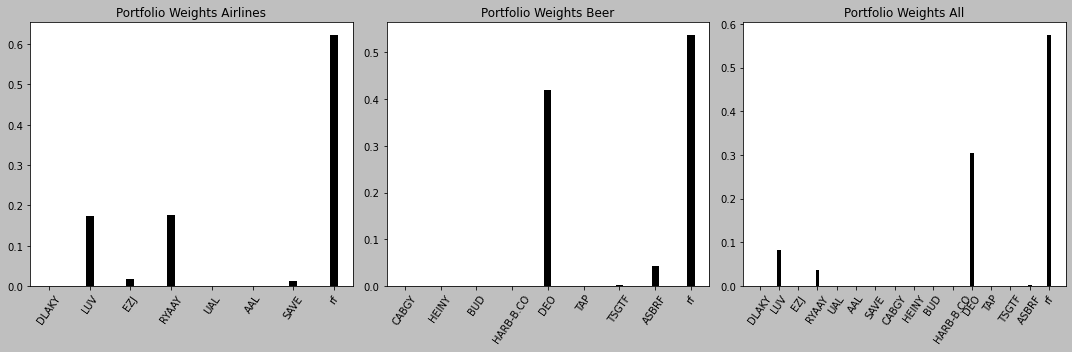

In [32]:
fig, axes = plt.subplots(1,3,figsize=(15,5))
names = ['Airlines', 'Beer', 'All']

for i, port in zip(range(len(target_port_list_rf)),target_port_list_rf):
    axes[i].bar(np.arange(len(port['weight'][0])),port['weight'][0],width=0.2) 

for info_df, i, name  in zip(info_df_list_rf, range(len(info_df_list_rf)),names):
    axes[i].set_xticks(np.arange(len(info_df['stock']))) 
    axes[i].set_xticklabels(info_df['stock'],rotation = 55)
    
    title = 'Portfolio Weights ' + name
    
    axes[i].set_title(title)

fig.tight_layout()

In [19]:
fig.savefig('/Users/frederikfindsen/Documents/GitHub/Project-Finance/assets/weights_port_rf')

In [35]:
for port in target_port_list:
    print(port)

        std   ret                                             weight
0  0.254351  0.06  [0.3313312184901403, 0.0, 0.51263356092104, 0....
        std   ret                                             weight
0  0.132248  0.06  [0.0, 0.0, 0.0, 0.3993319210432305, 0.41428787...
        std   ret                                             weight
0  0.131356  0.06  [0.011699083657262395, 5.014435047745458e-19, ...


In [141]:
df_list = [airlines_df, beer_df, df]
new_columns = ['portfolio_airline_norf',
               'portfolio_beer_norf',
              'portfolio_all_norf']

returns_list = list()
for port, df in zip(target_port_list, df_list):
    weighted_returns = port['weight'][0] * df
    returns = weighted_returns.sum(axis=1).values
    returns_list.append(returns)
    
for returns, name in zip(returns_list,new_columns):
    portfolios[name] = returns


In [147]:
new_columns = ['portfolio_airline_rf',
               'portfolio_beer_rf',
              'portfolio_all_rf']
df_list = [airlines_df, beer_df, df]
returns_list = list()
for port, df in zip(target_port_list_rf, df_list):
    weighted_returns = port['weight'][0] * df
    returns = weighted_returns.sum(axis=1).values
    returns_list.append(returns)
    
for returns, name in zip(returns_list,new_columns):
    portfolios[name] = returns

